# Policy Optimization under Linear Settings

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from hetero.algo import align_binary_labels, group
from hetero.config import (
    DEFAULT_GROUP_REWARD_COEFF_OVERRIDE,
    DTYPE,
    AlgoConfig,
    DataGenConfig,
    DimConfig,
    GroupingConfig,
)
from hetero.datagen import generate_data_from_config
from hetero.policies import AllPosPolicy, AlternativePolicy, SoftmaxPolicy
from hetero.utils import LabelPartitioner, remove_outlier

=====================================================================================================

In [3]:
# Linear setting hence no expansion settings.
# N=100 and N=30.

data_config = DataGenConfig(
    num_trajectories=100,
    num_time_steps=30,
    group_reward_coeff_override=np.array(
        [
            [-2.68, 2.68],
            [2.68, -2.68],
        ],
        dtype=DTYPE,
    ),
    action_reward_coeff=[-2.89, 2.89],
)
data = generate_data_from_config(data_config)
pi_eval = AlternativePolicy(data_config.NUM_ACTIONS)
discount = 0.6

In [4]:
from hetero.algo import beta_from_linreg
from hetero.utils import action_feature_prod

Z = action_feature_prod(data.actions, data.current_features)
pi_eval_actions = pi_eval.action(data.next_features)
U = action_feature_prod(pi_eval_actions, data.next_features)
print(Z.shape, U.shape)
beta = beta_from_linreg(data, Z, U, discount)
print(beta.shape)

(6000, 4) (6000, 4)
(200, 4)


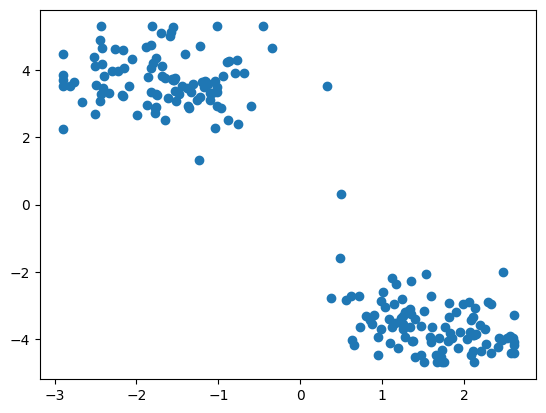

In [5]:
# Trajectory wise regression betas, only for demo.

init_beta = remove_outlier(beta, 2, 98)
# plt.scatter(init_beta[:, 0], init_beta[:, 1])

# Run Auto-Clustered Policy Evaluation

In [6]:
# Compute trajectory wise betas with optimizer

from hetero.algo import BetaOptimizer, MCPImpl

base_config = dict(
    discount=discount,
    max_num_iters=10,
    should_remove_outlier=True,
    outlier_lower_perc=2,
    outlier_upper_perc=98,
    nu_coeff=1e-4,
    delta_coeff=1e-4,
    use_group_wise_regression_init=True,
)

lam = 1.0
algo_config = AlgoConfig(lam=lam, **base_config)
impl = MCPImpl(data.N(), algo_config)
beta_opt = BetaOptimizer(data, algo_config, pi_eval, impl)
beta_optimized = beta_opt.compute()

beta_solver, min eigen of left matrix = (0.4433107-0.003586896j)
MCPImpl: num_above=16998, num_below=2902
beta_solver, min eigen of left matrix = (0.4433107-0.003586896j)
MCPImpl: num_above=17257, num_below=2643
beta_solver, min eigen of left matrix = (0.4433107-0.003586896j)
MCPImpl: num_above=16649, num_below=3251
beta_solver, min eigen of left matrix = (0.4433107-0.003586896j)
MCPImpl: num_above=16571, num_below=3329
beta_solver, min eigen of left matrix = (0.4433107-0.003586896j)
MCPImpl: num_above=16262, num_below=3638
beta_solver, min eigen of left matrix = (0.4433107-0.003586896j)
MCPImpl: num_above=16222, num_below=3678
beta_solver, min eigen of left matrix = (0.4433107-0.003586896j)
MCPImpl: num_above=16079, num_below=3821
beta_solver, min eigen of left matrix = (0.4433107-0.003586896j)
MCPImpl: num_above=16046, num_below=3854
beta_solver, min eigen of left matrix = (0.4433107-0.003586896j)
MCPImpl: num_above=15951, num_below=3949
beta_solver, min eigen of left matrix = (0.443

# # Run Auto-Clustered Policy Optimization

In [7]:
import collections
import importlib

import hetero.algo as algo_mod
import hetero.config as config_mod
import hetero.offline_rl as offline_rl_mod
import hetero.utils as utils_mod

algo_mod = importlib.reload(algo_mod)
config_mod = importlib.reload(config_mod)
offline_rl_mod = importlib.reload(offline_rl_mod)
utils_mod = importlib.reload(utils_mod)

learned_labels = algo_mod.group(
    beta_optimized, config_mod.GroupingConfig(num_clusters=2)
)

collections.Counter(learned_labels)

rl_split_pols = offline_rl_mod.split_sars_data_for_rl(data, learned_labels)
RL_PARAMS = offline_rl_mod.ActorCriticLearnerParams(
    lr=2e-2, decay=1e-4, grad_norm_clip=1000
)

kmeans center = [[ 1.51307692 -3.71641148  3.85826896 -1.52371956]
 [-1.59592641  3.73131928 -3.89060526  1.5532963 ]] and inertia = 799.097509461479


# Calculate Optimial Policy and it Value for Group 1

In [8]:
cluster = 0
rl_pol = rl_split_pols[cluster]

print(f"Perfoming RL for cluster={cluster} with {rl_pol.features().shape[0]} records")
acl_0 = offline_rl_mod.ActorCriticLeaner(rl_pol, params=RL_PARAMS)
acl_0.learn()
print(f"MEAN_Y_FINAL={acl_0.eval()} and #SAMPLES={acl_0.sample_pi.num_samples}")

Perfoming RL for cluster=0 with 3000 records
  * At actor-learn step 0, g_norm=2300.429(CLIP@1000), y=45.650
  * At actor-learn step 1, g_norm=2299.765(CLIP@1000), y=85.635
  * At actor-learn step 2, g_norm=2298.485(CLIP@1000), y=113.895
  * At actor-learn step 3, g_norm=2296.943(CLIP@1000), y=136.957
  * At actor-learn step 4, g_norm=2295.248(CLIP@1000), y=156.918
  * At actor-learn step 5, g_norm=2293.451(CLIP@1000), y=174.761
  * At actor-learn step 6, g_norm=2291.579(CLIP@1000), y=191.039
  * At actor-learn step 7, g_norm=2289.650(CLIP@1000), y=206.099
  * At actor-learn step 8, g_norm=2287.677(CLIP@1000), y=220.178
  * At actor-learn step 9, g_norm=2285.666(CLIP@1000), y=233.443
  * At actor-learn step 10, g_norm=2283.626(CLIP@1000), y=246.019
  * At actor-learn step 11, g_norm=2281.560(CLIP@1000), y=258.002
  * At actor-learn step 12, g_norm=2279.473(CLIP@1000), y=269.466
  * At actor-learn step 13, g_norm=2277.367(CLIP@1000), y=280.474
  * At actor-learn step 14, g_norm=2275.245

  * At actor-learn step 1, g_norm=208.242, y=2876.366
  * At actor-learn step 1, stopped at y=2876.366, prev_y=2867.971, relative_error=0.003
* At alter step 32, diff_norm=0.067, cur_norm=2.864, relative_error=0.023
  * At actor-learn step 0, g_norm=203.959, y=2882.086
  * At actor-learn step 1, g_norm=197.981, y=2890.064
  * At actor-learn step 1, stopped at y=2890.064, prev_y=2882.086, relative_error=0.003
* At alter step 33, diff_norm=0.067, cur_norm=2.932, relative_error=0.023
  * At actor-learn step 0, g_norm=193.963, y=2895.500
  * At actor-learn step 1, g_norm=188.353, y=2903.087
  * At actor-learn step 1, stopped at y=2903.087, prev_y=2895.500, relative_error=0.003
* At alter step 34, diff_norm=0.067, cur_norm=2.999, relative_error=0.022
  * At actor-learn step 0, g_norm=184.581, y=2908.261
  * At actor-learn step 1, g_norm=179.314, y=2915.481
  * At actor-learn step 1, stopped at y=2915.481, prev_y=2908.261, relative_error=0.002
* At alter step 35, diff_norm=0.067, cur_norm=3.

# Calculate Optimial Policy and it Value for Group 2

In [9]:
cluster = 1
rl_pol = rl_split_pols[cluster]

print(f"Perfoming RL for cluster={cluster} with {rl_pol.features().shape[0]} records")
acl_1 = offline_rl_mod.ActorCriticLeaner(rl_pol, params=RL_PARAMS)
acl_1.learn()
print(f"MEAN_Y_FINAL={acl_1.eval()} and #SAMPLES={acl_1.sample_pi.num_samples}")

Perfoming RL for cluster=1 with 3000 records
  * At actor-learn step 0, g_norm=2115.191(CLIP@1000), y=-56.466
  * At actor-learn step 1, g_norm=2114.463(CLIP@1000), y=-16.480
  * At actor-learn step 2, g_norm=2113.106(CLIP@1000), y=11.780
  * At actor-learn step 3, g_norm=2111.481(CLIP@1000), y=34.841
  * At actor-learn step 4, g_norm=2109.702(CLIP@1000), y=54.799
  * At actor-learn step 5, g_norm=2107.820(CLIP@1000), y=72.639
  * At actor-learn step 6, g_norm=2105.861(CLIP@1000), y=88.912
  * At actor-learn step 7, g_norm=2103.846(CLIP@1000), y=103.968
  * At actor-learn step 8, g_norm=2101.786(CLIP@1000), y=118.041
  * At actor-learn step 9, g_norm=2099.690(CLIP@1000), y=131.301
  * At actor-learn step 10, g_norm=2097.564(CLIP@1000), y=143.870
  * At actor-learn step 11, g_norm=2095.413(CLIP@1000), y=155.846
  * At actor-learn step 12, g_norm=2093.241(CLIP@1000), y=167.303
  * At actor-learn step 13, g_norm=2091.052(CLIP@1000), y=178.302
  * At actor-learn step 14, g_norm=2088.846(CL

  * At actor-learn step 0, g_norm=80.665, y=2865.704
  * At actor-learn step 1, g_norm=78.884, y=2868.840
  * At actor-learn step 1, stopped at y=2868.840, prev_y=2865.704, relative_error=0.001
* At alter step 53, diff_norm=0.067, cur_norm=4.437, relative_error=0.015
  * At actor-learn step 0, g_norm=77.676, y=2871.024
  * At actor-learn step 1, g_norm=75.979, y=2874.044
  * At actor-learn step 1, stopped at y=2874.044, prev_y=2871.024, relative_error=0.001
* At alter step 54, diff_norm=0.067, cur_norm=4.504, relative_error=0.015
  * At actor-learn step 0, g_norm=74.827, y=2876.144
  * At actor-learn step 1, g_norm=73.209, y=2879.052
  * At actor-learn step 1, stopped at y=2879.052, prev_y=2876.144, relative_error=0.001
* At alter step 55, diff_norm=0.067, cur_norm=4.571, relative_error=0.015
  * At actor-learn step 0, g_norm=72.111, y=2881.084
  * At actor-learn step 1, g_norm=70.569, y=2883.886
  * At actor-learn step 1, stopped at y=2883.886, prev_y=2881.084, relative_error=0.001
* 

# Classic Mean-Value based Optimal Policy and its Value for Group 1 and 2 Respectively

In [10]:
rl_pols_comb = offline_rl_mod.split_sars_data_for_rl(data, [0] * data.NT())
RL_PARAMS = offline_rl_mod.ActorCriticLearnerParams(
    lr=1e-2, decay=1e-4, grad_norm_clip=1000
)

cluster = 0
rl_pol = rl_pols_comb[cluster]

print(f"Perfoming RL for cluster={cluster} with {rl_pol.features().shape[0]} records")
acl_comb = offline_rl_mod.ActorCriticLeaner(rl_pol, params=RL_PARAMS)
acl_comb.learn()
print(f"MEAN_Y_FINAL_COMB={acl_comb.eval()} and #SAMPLES={acl_comb.sample_pi.num_samples}")

from hetero.policies import SoftmaxPolicy
print(f"MEAN_Y_FINAL_0={acl_0.eval()} and #SAMPLES={acl_0.sample_pi.num_samples}")
print(f"MEAN_Y_FINAL_1={acl_1.eval()} and #SAMPLES={acl_1.sample_pi.num_samples}")
print(f"MEAN_Y_FINAL_COMB={acl_comb.eval()} and #SAMPLES={acl_comb.sample_pi.num_samples}")

for i in range(2):
    print(f"Combined pol eval on cluser {i} =", rl_split_pols[i].fit_then_eval(SoftmaxPolicy(acl_comb.weights()), algo_config.discount))

Perfoming RL for cluster=0 with 6000 records
  * At actor-learn step 0, g_norm=385.508, y=1.732
  * At actor-learn step 1, g_norm=385.302, y=8.527
  * At actor-learn step 2, g_norm=385.002, y=13.327
  * At actor-learn step 3, g_norm=384.664, y=17.239
  * At actor-learn step 4, g_norm=384.303, y=20.621
  * At actor-learn step 5, g_norm=383.928, y=23.640
  * At actor-learn step 6, g_norm=383.542, y=26.390
  * At actor-learn step 7, g_norm=383.149, y=28.932
  * At actor-learn step 8, g_norm=382.751, y=31.304
  * At actor-learn step 9, g_norm=382.348, y=33.536
  * At actor-learn step 10, g_norm=381.942, y=35.650
  * At actor-learn step 11, g_norm=381.534, y=37.660
  * At actor-learn step 12, g_norm=381.123, y=39.581
  * At actor-learn step 13, g_norm=380.711, y=41.423
  * At actor-learn step 14, g_norm=380.297, y=43.194
  * At actor-learn step 15, g_norm=379.883, y=44.901
  * At actor-learn step 16, g_norm=379.468, y=46.551
  * At actor-learn step 17, g_norm=379.053, y=48.147
  * At actor-

  * At actor-learn step 2, g_norm=207.769, y=283.381
  * At actor-learn step 2, stopped at y=283.381, prev_y=281.185, relative_error=0.008
* At alter step 12, diff_norm=0.044, cur_norm=1.061, relative_error=0.042
  * At actor-learn step 0, g_norm=206.074, y=285.092
  * At actor-learn step 1, g_norm=203.171, y=288.149
  * At actor-learn step 2, g_norm=201.188, y=290.248
  * At actor-learn step 2, stopped at y=290.248, prev_y=288.149, relative_error=0.007
* At alter step 13, diff_norm=0.044, cur_norm=1.105, relative_error=0.040
  * At actor-learn step 0, g_norm=199.571, y=291.885
  * At actor-learn step 1, g_norm=196.793, y=294.808
  * At actor-learn step 2, g_norm=194.901, y=296.816
  * At actor-learn step 2, stopped at y=296.816, prev_y=294.808, relative_error=0.007
* At alter step 14, diff_norm=0.044, cur_norm=1.150, relative_error=0.038
  * At actor-learn step 0, g_norm=193.361, y=298.380
  * At actor-learn step 1, g_norm=190.706, y=301.176
  * At actor-learn step 1, stopped at y=301

  * At actor-learn step 1, g_norm=102.242, y=398.635
  * At actor-learn step 1, stopped at y=398.635, prev_y=397.196, relative_error=0.004
* At alter step 44, diff_norm=0.024, cur_norm=1.777, relative_error=0.013
  * At actor-learn step 0, g_norm=101.330, y=399.615
  * At actor-learn step 1, g_norm=100.027, y=401.023
  * At actor-learn step 1, stopped at y=401.023, prev_y=399.615, relative_error=0.004
* At alter step 45, diff_norm=0.024, cur_norm=1.799, relative_error=0.013
  * At actor-learn step 0, g_norm=99.140, y=401.982
  * At actor-learn step 1, g_norm=97.864, y=403.359
  * At actor-learn step 1, stopped at y=403.359, prev_y=401.982, relative_error=0.003
* At alter step 46, diff_norm=0.024, cur_norm=1.821, relative_error=0.013
  * At actor-learn step 0, g_norm=97.002, y=404.298
  * At actor-learn step 1, g_norm=95.751, y=405.645
  * At actor-learn step 1, stopped at y=405.645, prev_y=404.298, relative_error=0.003
* At alter step 47, diff_norm=0.024, cur_norm=1.843, relative_error

# Examing specific samples

## Results for Table 2 

In [37]:
# Group One Sample

i = 15

sample_0 = rl_split_pols[0].current_features[i,:]
print(sample_0)
learned_0 = SoftmaxPolicy(acl_0.weights())
learned_1 = SoftmaxPolicy(acl_1.weights())
learned_comb = SoftmaxPolicy(acl_comb.weights())
print("learned 0 applied to sample 0 =", learned_0.action(sample_0))
print("learned 1 applied to sample 0 =", learned_1.action(sample_0))
print("learned comb applied to sample 0 =", learned_comb.action(sample_0))

[0.46182945 0.07625238]
learned 0 applied to sample 0 = [0.02581714 0.9741829 ]
learned 1 applied to sample 0 = [0.9746739  0.02532613]
learned comb applied to sample 0 = [0.599927   0.40007296]


In [14]:
# Group Two Sample

j = 10

sample_1 = rl_split_pols[1].current_features[j,:]
print(sample_1)
print("learned 0 applied to sample 1 =", learned_0.action(sample_1))
print("learned 1 applied to sample 1 =", learned_1.action(sample_1))
print("learned comb applied to sample 1 =", learned_comb.action(sample_1))

[-0.05325912 -0.14394619]
learned 0 applied to sample 1 = [0.79112923 0.20887081]
learned 1 applied to sample 1 = [0.20817189 0.7918281 ]
learned comb applied to sample 1 = [0.5938053 0.4061947]
